<a href="https://colab.research.google.com/github/tiitvaino/NAI22_hand_drawn_sketches/blob/main/load_preprocesss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import json
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display
import cv2


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import  Bidirectional, LSTM, Activation, Dense, Reshape
from keras.layers import  Convolution2D, MaxPooling2D, Flatten, BatchNormalization


In [2]:
# loading sketches 
#!gsutil -mq cp 'gs://quickdraw_dataset/full/simplified/*.ndjson' .
!gsutil -mq cp 'gs://quickdraw_dataset/full/simplified/angel.ndjson' .
!gsutil -mq cp 'gs://quickdraw_dataset/full/simplified/ant.ndjson' .

In [34]:
def read_sketch_data(file_name:str, max_nr_elements:int=None, good_only:bool=True)->pd.DataFrame:
  """
  Read from info about one class of sketches data.
  If max_nr_elements==None then all info is read.
  If good_only==False then all sketces info is saved.
  """
  df = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
  nr_elements = 0
  with open(file_name) as f:
    for row in f.readlines():
      data = json.loads(row)
      df_row = pd.DataFrame.from_dict(data,orient='index').T
      if not df_row['recognized'].iloc[0]:
        continue
      df = df.append([df_row])
      if max_nr_elements != None:
        nr_elements+=1
        if max_nr_elements <= nr_elements:
          break
  # get only good pictures
  if good_only:
    df = df[df.recognized == True]
  return df

def read_sketches_data(class_names:list=None,max_nr_imgs_per_cls:int=None)->pd.DataFrame:
  """"
  Read every desired class info into one dataframe.
  """
  data_files = list(filter(lambda x: '.ndjson' in x, os.listdir()))

  df_sketches = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])

  for class_name in data_files:
    if class_names and class_name[:-len('.ndjson')] not in class_names:
      continue
    df_sketches = df_sketches.append([read_sketch_data(class_name, max_nr_imgs_per_cls)])
  
  return df_sketches

In [45]:
def vector_to_img(vector)->np.array:
  def resize_point(x,y,size_from_original)->tuple:
    return round(x*size_from_original),round(y*size_from_original)

  stroke_locs =  [list(zip(stroke[0],stroke[1]))for stroke in vector]
  image = np.full((100,100,3),(255,255,255),dtype=np.uint8)
  for stroke in stroke_locs:
    last_point = resize_point(int(stroke[0][0]),int(stroke[0][1]),0.25)
    for x,y in stroke:
      new_point = resize_point(int(x),int(y),0.25)
      cv2.line(image, last_point, new_point, (0,0,0), 2)
      last_point = new_point
  return image

def visualise_sketch(image):
  display(Image.fromarray(image))

def preprocess_cnn(df:pd.DataFrame)->tuple:
  x=df.apply(lambda row: vector_to_img(row['drawing'])/255.0,axis=1).values 

  class_names = df['word'].str.get_dummies().columns
  y = df['word'].str.get_dummies().values

  return x,y,class_names

In [46]:
df = read_sketches_data(max_nr_imgs_per_cls=3)
df

,word,countrycode,timestamp,recognized,key_id,drawing
0,angel,US,2017-03-03 20:39:08.85189 UTC,True,6665588124418048,"[[[128, 116, 99, 87, 77, 75, 80, 90, 114, 130,..."
0,angel,JP,2017-03-05 05:52:48.49661 UTC,True,5275268287561728,"[[[98, 74, 52, 46, 44, 52, 63, 82, 116, 137, 1..."
0,angel,SE,2017-03-16 15:26:18.80779 UTC,True,5492710351831040,"[[[140, 153, 174, 183, 210, 224, 227, 228, 221..."
0,ant,US,2017-03-27 00:14:57.31033 UTC,True,5421013154136064,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4..."
0,ant,US,2017-03-06 20:00:22.52156 UTC,True,4836123148812288,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ..."
0,ant,US,2017-01-23 19:53:28.35453 UTC,True,5720952853757952,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89..."


[100] spent seconds: 0.5339617310000904
[200] spent seconds: 0.989164064999386
[300] spent seconds: 1.1677360789999511
[400] spent seconds: 1.459689838000486
[500] spent seconds: 2.1141811960005725
[600] spent seconds: 2.2112648820002505
[700] spent seconds: 2.369284226999298
[800] spent seconds: 2.6694920359996104


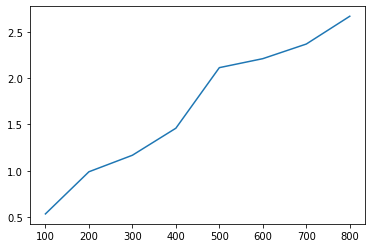

In [58]:
import time
times = []
steps=[]
start = 100
stop = 800
step = 100
for i in range(start,stop+1,step):
  start = time.perf_counter()
  df = read_sketches_data(max_nr_imgs_per_cls=i)
  res = preprocess_cnn(df)
  end = time.perf_counter()
  spent_seconds = end-start
  times.append(spent_seconds)
  steps.append(i)
  print(f'[{i}] spent seconds: {spent_seconds}')

plt.plot(steps,times)
plt.show()

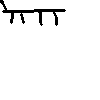

In [57]:
visualise_sketch(vector_to_img(df['drawing'].iloc[-3]))